In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.io import loadmat

# Load the data
# data_file = np.load('max_anomoly_metric.npz')
# data = data_file['data']
# model_dir = '../2D_32_noise/'
model_dir = '../2D_64_spectral_dt0.02_noise_2500/'

# dt_data = 2e-2

data_train = np.load(model_dir + 'train_UV_max_min.npz')
data_model = np.load(model_dir + 'model_UV_max_min.npz')

U_std = 2.25
V_std = 2.25

U_max_train = data_train['U_max'].flatten()/U_std
U_min_train = data_train['U_min'].flatten()/U_std
V_max_train = data_train['V_max'].flatten()/V_std
V_min_train = data_train['V_min'].flatten()/V_std

U_max_model = data_model['U_max'].flatten()/U_std
U_min_model = data_model['U_min'].flatten()/U_std
V_max_model = data_model['V_max'].flatten()/V_std
V_min_model = data_model['V_min'].flatten()/V_std

desired_length = 200000
if len(U_max_train) > desired_length:
    U_max_train = U_max_train[:desired_length]
    U_min_train = U_min_train[:desired_length]
    V_max_train = V_max_train[:desired_length]
    V_min_train = V_min_train[:desired_length]


U_max_train_split = np.array_split(U_max_train, 10)
U_min_train_split = np.array_split(U_min_train, 10)
V_max_train_split = np.array_split(V_max_train, 10)
V_min_train_split = np.array_split(V_min_train, 10)


desired_length = 40000
if len(U_max_train) > desired_length:
    U_max_model = U_max_model[:desired_length]
    U_min_model = U_min_model[:desired_length]
    V_max_model = V_max_model[:desired_length]
    V_min_model = V_min_model[:desired_length]

U_max_model_split = np.array_split(U_max_model, 2)
U_min_model_split = np.array_split(U_min_model, 2)
V_max_model_split = np.array_split(V_max_model, 2)
V_min_model_split = np.array_split(V_min_model, 2)

dt = 2e-2 # time step

FileNotFoundError: [Errno 2] No such file or directory: '../2D_64_spectral_dt0.02_noise_2500/train_UV_max_min.npz'

In [ ]:
def return_period(data, bins=50, bin_range=None):
    '''
    Return period for a time series data
    Inverse of the exedance probability
    https://www.pnas.org/doi/full/10.1073/pnas.1716222114'''

    freq, bins = np.histogram(data, bins=bins, range=bin_range)
    bins = (bins[1:] + bins[:-1]) / 2
    freq_total = np.zeros(freq.shape)
    for count, value in enumerate(freq):
        freq_total[count] = np.sum(freq[:count+1])
    freq_total = freq_total / np.sum(freq)

    return 1/(1-freq_total), freq_total, bins


return_period_kerry, freq_tot, bins_max = return_period(data_normalized[0,:], bins=50)
plt.semilogy(bins_max, return_period_kerry, 'sb')
plt.ylabel('Return Period')

In [15]:
def freq_excedance_from_freq(freq):
    '''Cummulative frequency above threshold value'''
    freq_total = np.zeros(freq.shape)
    for count, value in enumerate(freq):
        freq_total[count] = np.sum(freq[:count+1])
    return (np.sum(freq) - freq_total)

def return_period_ensemble(data, dt=1, bins=50, uncertainity='freq_excedance'):
    '''Calculate return period using ensemble of data
    data: 2D array of data [ensemble, time]
    dt: time step
    bins: number of bins for binning the data
    uncertainity: 'freq' / 'freq_excedance': Maps the uncertainity from frequency/frequency_excedance to return period respectively
    '''

    number_ensemble = data.shape[0]
    length_time_series = data.shape[1]

    bin_min = np.min(data)
    bin_max = np.max(data)

    # Initializing variables to store ensemble of frequency and frequency_excedance
    freq_excedance_ensemble = []
    freq_ensemble = []

    # Calculating frequency for each member of the ensemble
    for i in range(number_ensemble):

        data_ensemble = data[i,:]

        # Bin the data and calculate frequency in each bin
        freq_sample, bins_data = np.histogram(data_ensemble, bins=bins, range=(bin_min, bin_max ))
        bins_data = (bins_data[1:] + bins_data[:-1]) / 2 # Mid point of the bins
        freq_excedance_sample = freq_excedance_from_freq(freq_sample)

        freq_ensemble.append(freq_sample)
        freq_excedance_ensemble.append(freq_excedance_sample)

    print(np.array(freq_ensemble).shape)

    # Mean and standard deviation of the ensemble

    if uncertainity == 'freq':
        # Calculate uncertainity in frequency and map it to return period

        freq_ensemble_mean = np.mean(freq_ensemble, axis=0)
        freq_ensemble_std = np.std(freq_ensemble, axis=0)

        freq_ensemble_min = freq_ensemble_mean - freq_ensemble_std
        freq_ensemble_max = freq_ensemble_mean + freq_ensemble_std

        freq_excedance_ensemble_mean = freq_excedance_from_freq(freq_ensemble_mean)
        freq_excedance_ensemble_min = freq_excedance_from_freq(freq_ensemble_min)
        freq_excedance_ensemble_max = freq_excedance_from_freq(freq_ensemble_max)

    elif uncertainity == 'freq_excedance':
        # Calculate uncertainity in frequency_excedance and map it to return period

        freq_excedance_ensemble_mean = np.mean(freq_excedance_ensemble, axis=0)
        freq_excedance_ensemble_std = np.std(freq_excedance_ensemble, axis=0)

        freq_excedance_ensemble_min = freq_excedance_ensemble_mean - freq_excedance_ensemble_std
        freq_excedance_ensemble_max = freq_excedance_ensemble_mean + freq_excedance_ensemble_std

    # Calculate probability of exceedance
    prob_excedance_ensemble_mean = (freq_excedance_ensemble_mean/np.sum(freq_excedance_ensemble_mean))
    prob_excedance_ensemble_min = (freq_excedance_ensemble_min/np.sum(freq_excedance_ensemble_min))
    prob_excedance_ensemble_max = (freq_excedance_ensemble_max/np.sum(freq_excedance_ensemble_max))

    # Probability of exceedance should be between 0 and 1
    # Return period should be positive (>= dt)
    prob_excedance_ensemble_min[prob_excedance_ensemble_min > 1] = 1
    prob_excedance_ensemble_min[prob_excedance_ensemble_min <= 0] = 1e-14

    prob_excedance_ensemble_max[prob_excedance_ensemble_max > 1] = 1
    prob_excedance_ensemble_max[prob_excedance_ensemble_max <= 0] = 1e-14

    # Calculate return period
    return_period_ensemble_mean = 1/prob_excedance_ensemble_mean * dt
    return_period_ensemble_mean_min = 1/prob_excedance_ensemble_min * dt
    return_period_ensemble_mean_max = 1/prob_excedance_ensemble_max * dt

    return return_period_ensemble_mean, return_period_ensemble_mean_min, return_period_ensemble_mean_max, bins_data



(10, 50)
(2, 50)
(10, 50)
(2, 50)


/tmp/ipykernel_266507/1381576690.py:79: RuntimeWarning: divide by zero encountered in divide
  return_period_ensemble_mean = 1/prob_excedance_ensemble_mean * dt


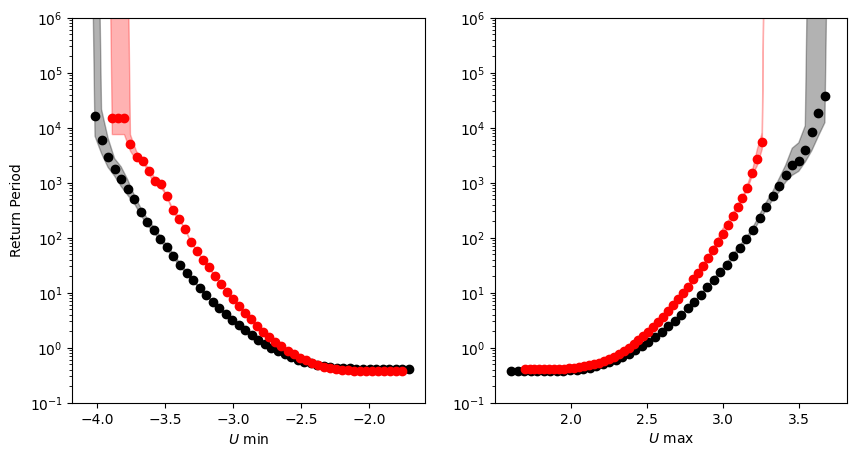

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

return_period_mean, return_period_min, return_period_max, bins = return_period_ensemble(
    np.abs(U_min_train_split), dt=dt, bins=50, uncertainity='freq_excedance')

axes[0].semilogy(-bins, return_period_mean, 'ok')
axes[0].fill_between(-bins, return_period_min, return_period_max, color='k', alpha=0.3)

return_period_mean, return_period_min, return_period_max, bins = return_period_ensemble(
    np.abs(U_min_model_split), dt=dt, bins=50, uncertainity='freq_excedance')

axes[0].semilogy(-bins, return_period_mean, 'or')
axes[0].fill_between(-bins, return_period_min, return_period_max, color='r', alpha=0.3)

axes[0].set_xlabel('$U$ min')
axes[0].set_ylabel('Return Period')

return_period_mean, return_period_min, return_period_max, bins = return_period_ensemble(
    np.asarray(U_max_train_split), dt=dt, bins=50, uncertainity='freq_excedance')

axes[1].semilogy(bins, return_period_mean, 'ok')
axes[1].fill_between(bins, return_period_min, return_period_max, color='k', alpha=0.3)

return_period_mean, return_period_min, return_period_max, bins = return_period_ensemble(
    np.abs(U_max_model_split), dt=dt, bins=50, uncertainity='freq_excedance')

axes[1].semilogy(bins, return_period_mean, 'or')
axes[1].fill_between(bins, return_period_min, return_period_max, color='r', alpha=0.3)

axes[1].set_xlabel('$U$ max')

for ax in axes.flatten():
    ax.set_ylim([1e-1, 1e6])
    # ax.set_xlim([-0.5, 0.5])

(10, 50)
(2, 50)
(10, 50)
(2, 50)


/tmp/ipykernel_266507/1381576690.py:79: RuntimeWarning: divide by zero encountered in divide
  return_period_ensemble_mean = 1/prob_excedance_ensemble_mean * dt


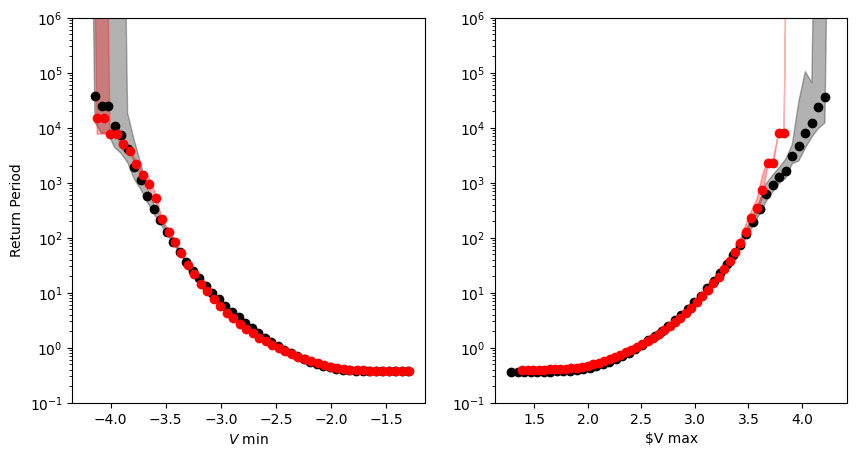

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

return_period_mean, return_period_min, return_period_max, bins = return_period_ensemble(
    np.abs(V_min_train_split), dt=dt, bins=50, uncertainity='freq_excedance')

axes[0].semilogy(-bins, return_period_mean, 'ok')
axes[0].fill_between(-bins, return_period_min, return_period_max, color='k', alpha=0.3)

return_period_mean, return_period_min, return_period_max, bins = return_period_ensemble(
    np.abs(V_min_model_split), dt=dt, bins=50, uncertainity='freq_excedance')

axes[0].semilogy(-bins, return_period_mean, 'or')
axes[0].fill_between(-bins, return_period_min, return_period_max, color='r', alpha=0.3)

axes[0].set_xlabel('$V$ min')
axes[0].set_ylabel('Return Period')

return_period_mean, return_period_min, return_period_max, bins = return_period_ensemble(
    np.asarray(V_max_train_split), dt=dt, bins=50, uncertainity='freq_excedance')

axes[1].semilogy(bins, return_period_mean, 'ok')
axes[1].fill_between(bins, return_period_min, return_period_max, color='k', alpha=0.3)

return_period_mean, return_period_min, return_period_max, bins = return_period_ensemble(
    np.abs(V_max_model_split), dt=dt, bins=50, uncertainity='freq_excedance')

axes[1].semilogy(bins, return_period_mean, 'or')
axes[1].fill_between(bins, return_period_min, return_period_max, color='r', alpha=0.3)

axes[1].set_xlabel('$V max')

for ax in axes.flatten():
    ax.set_ylim([1e-1, 1e6])
    # ax.set_xlim([-0.5, 0.5])